# EDA

In [1]:

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('data.csv')

In [2]:
data = data.drop(columns=['Unnamed: 0'])

In [3]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
data['date_time'] = pd.to_datetime(data['date_time'])
data['datetime'] = pd.to_datetime(data['datetime'])

## Temporal Analysis

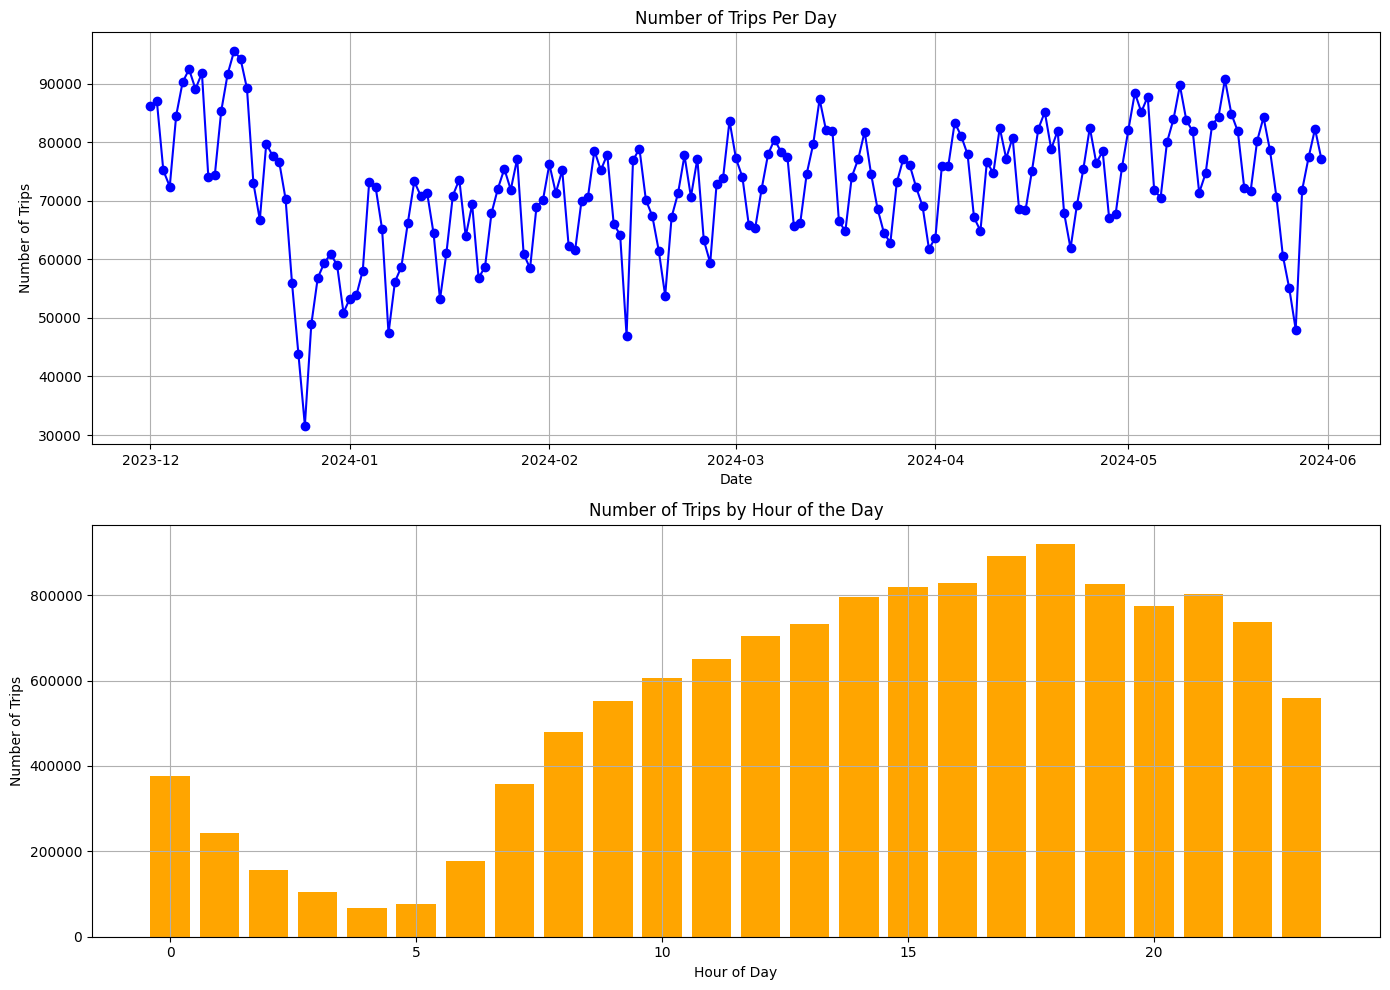

In [4]:

# Step 1: Trip Counts Over Time (Daily)
daily_trips = data.groupby('date_time').size()

# Step 2: Hourly Patterns
hourly_trips = data.groupby('hour').size()

# Plotting the results
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Trip Counts Over Time
ax[0].plot(daily_trips.index, daily_trips.values, marker='o', linestyle='-', color='b')
ax[0].set_title('Number of Trips Per Day')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of Trips')
ax[0].grid(True)

# Hourly Patterns
ax[1].bar(hourly_trips.index, hourly_trips.values, color='orange')
ax[1].set_title('Number of Trips by Hour of the Day')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Number of Trips')
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Geospatial Analysis

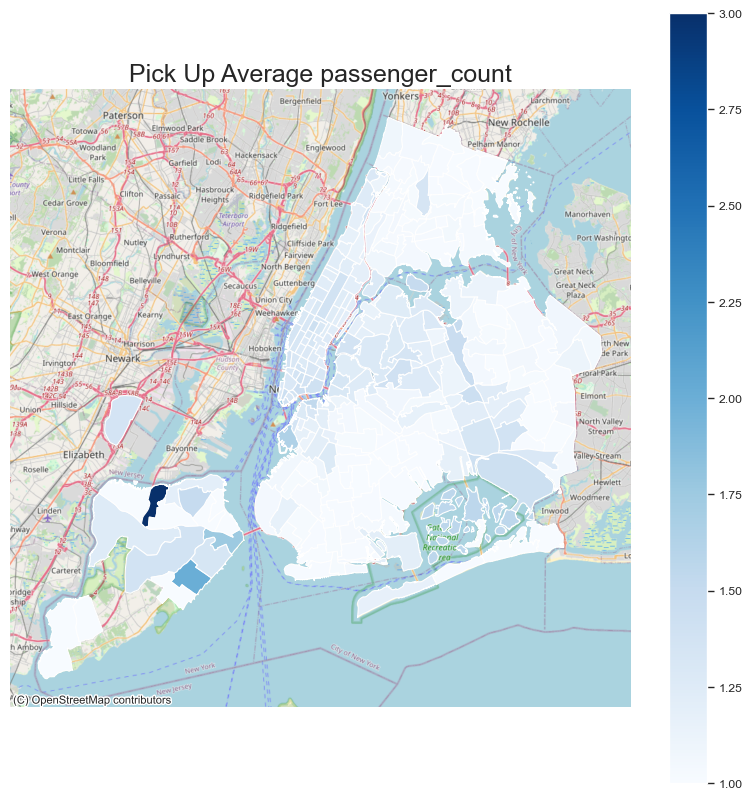

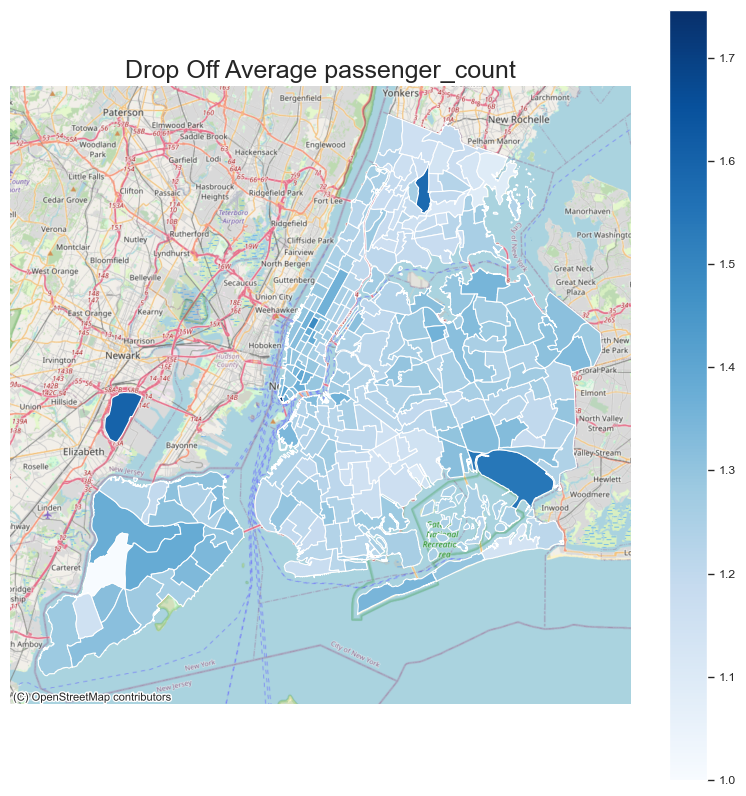

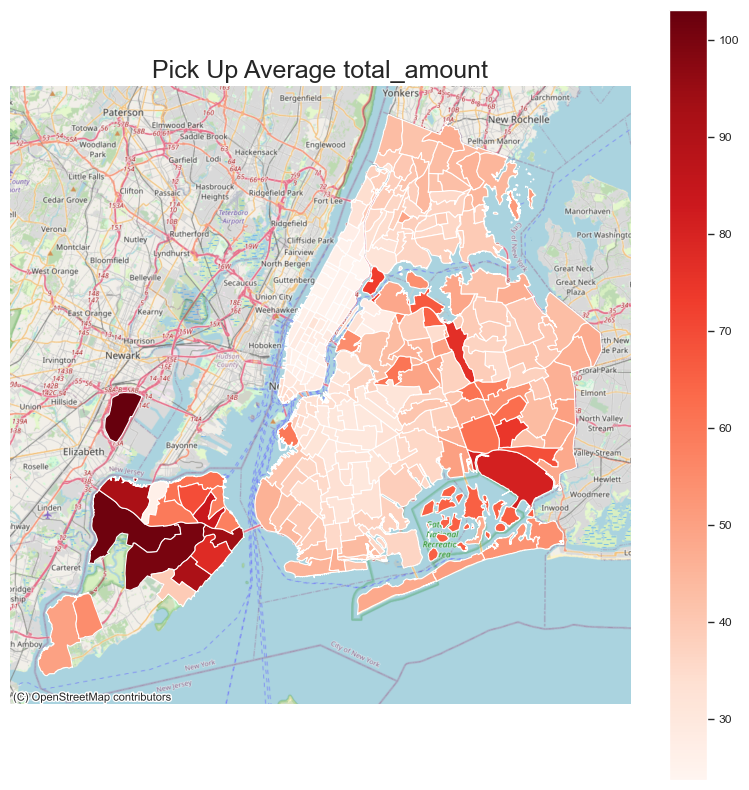

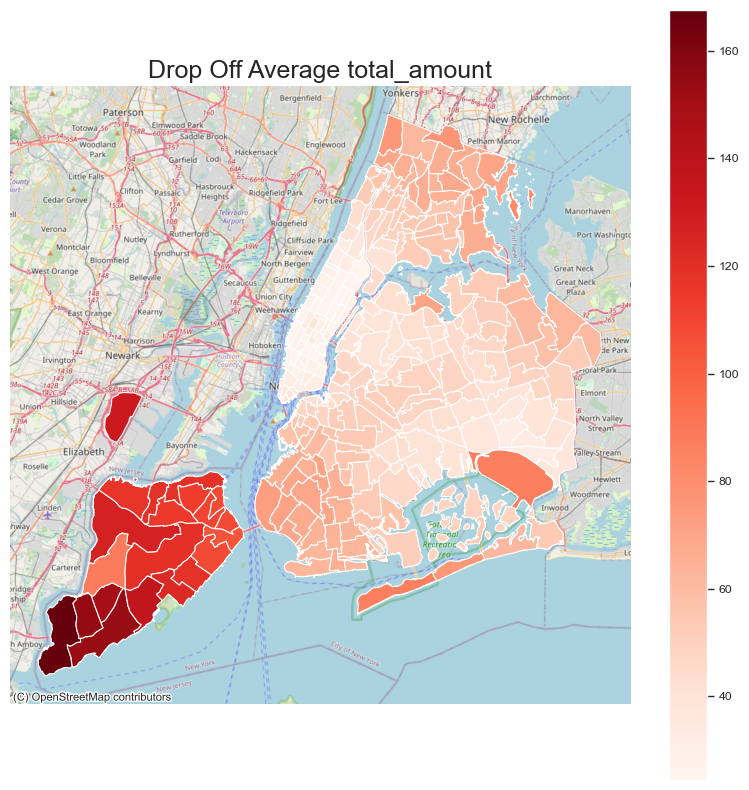

In [7]:
# Load and reproject the taxi zones shapefile
taxi_zones = gpd.read_file('../data/taxi_zones/taxi_zones.shp')
taxi_zones = taxi_zones.to_crs(epsg=3857)  # Reproject once

# Function to process and plot the geospatial data
def plot_geospatial_data(feature, taxi_zones, data, location_col, title, cmap):
    zone_data = data[[location_col, feature]].groupby(location_col, as_index=False).mean()
    merged_zone = gpd.GeoDataFrame(pd.merge(zone_data,
                                            taxi_zones,
                                            left_on=location_col,
                                            right_on='LocationID')).drop('LocationID', axis=1)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax = merged_zone.plot(column=feature,
                          cmap=cmap,
                          ax=ax)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  
    ax.set_title(title, fontsize=18)
    ax.set_axis_off()

    fig.colorbar(ax.collections[0], ax=ax, orientation="vertical")
    plt.show()

# # Set theme and context for seaborn
sns.set_theme()
sns.set_context("paper")

# Define the features and corresponding color palettes
features = ['passenger_count', 'total_amount']
color_palettes = ["Blues", 'Reds']

# Plot for each feature in both pickup and dropoff zones
for feature, cmap in zip(features, color_palettes):
    plot_geospatial_data(feature, taxi_zones, data, 'PULocationID', f'Pick Up Average {feature}', cmap)
    plot_geospatial_data(feature, taxi_zones, data, 'DOLocationID', f'Drop Off Average {feature}', cmap)



## Fare Analysis

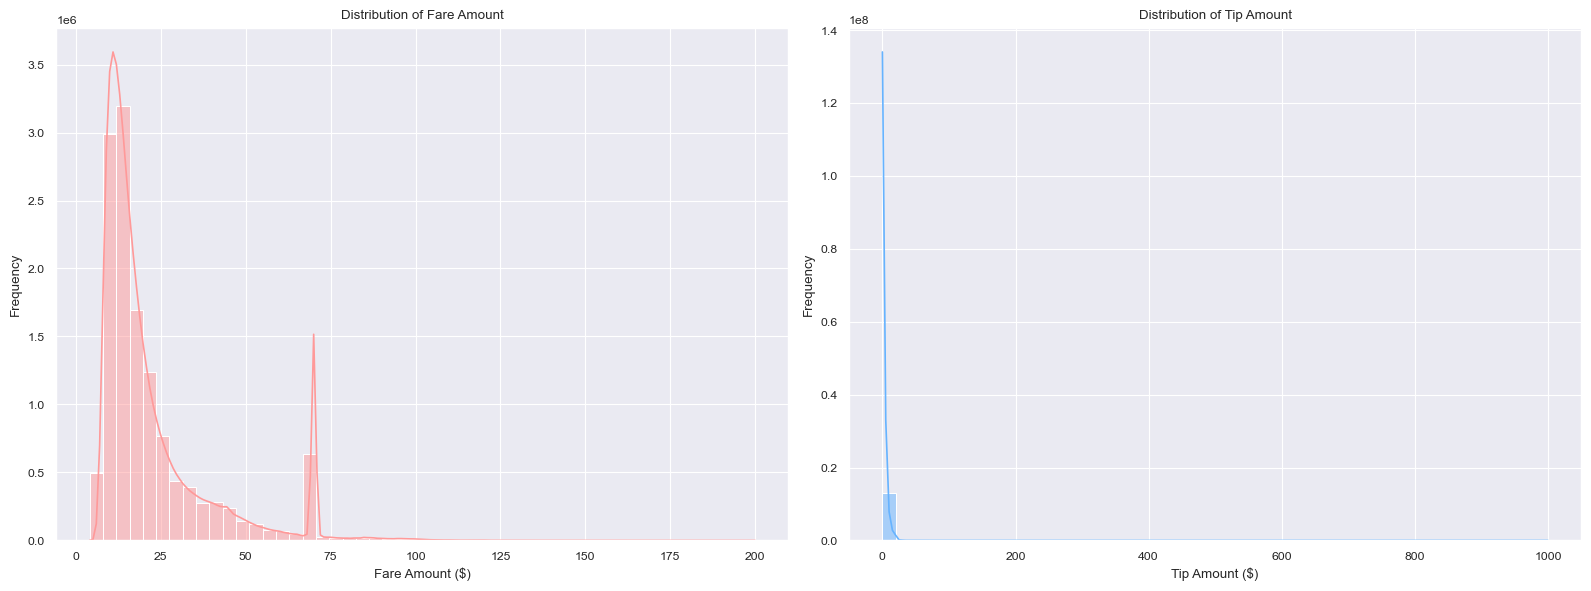

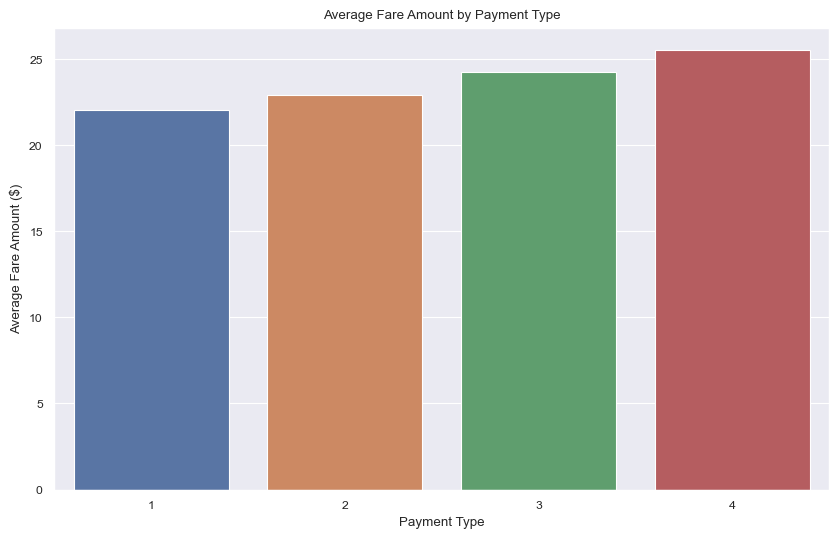

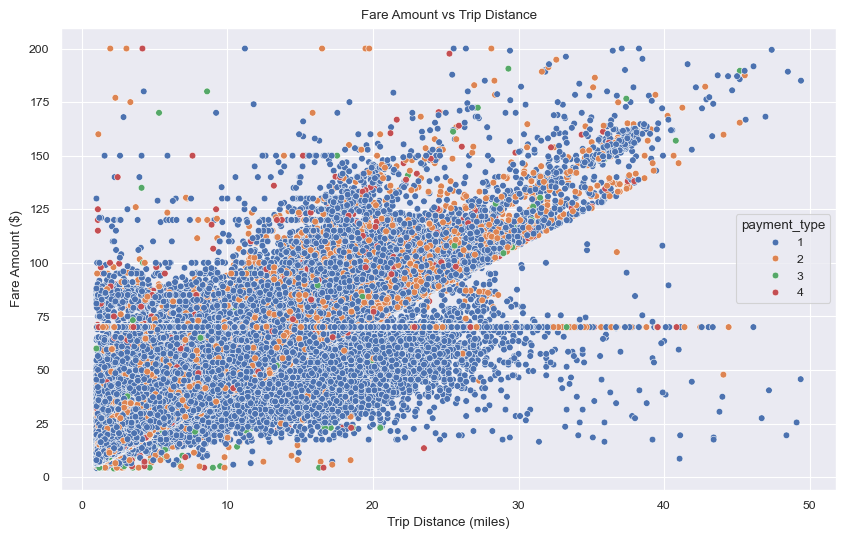

In [8]:
# Step 1: Distribution of Fare Amounts
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Fare Amount Distribution
sns.histplot(data['fare_amount'], bins=50, kde=True, ax=ax[0], color='#ff9999')
ax[0].set_title('Distribution of Fare Amount')
ax[0].set_xlabel('Fare Amount ($)')
ax[0].set_ylabel('Frequency')

# Tip Amount Distribution
sns.histplot(data['tip_amount'], bins=50, kde=True, ax=ax[1], color='#66b3ff')
ax[1].set_title('Distribution of Tip Amount')
ax[1].set_xlabel('Tip Amount ($)')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Step 2: Payment Methods Analysis
payment_fare = data.groupby('payment_type')['fare_amount'].mean().reset_index()

# Plotting Payment Method Distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='payment_type', y='fare_amount', data=payment_fare, ax=ax, palette='deep')
ax.set_title('Average Fare Amount by Payment Type')
ax.set_xlabel('Payment Type')
ax.set_ylabel('Average Fare Amount ($)')
plt.show()

# Step 3: Fare vs Trip Distance
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=data.sample(frac=0.3), ax=ax, hue='payment_type', palette='deep')
ax.set_title('Fare Amount vs Trip Distance')
ax.set_xlabel('Trip Distance (miles)')
ax.set_ylabel('Fare Amount ($)')
plt.show()


## Weather Impact

In [9]:
cols = ['passenger_count', 'trip_distance', 'total_amount',
        'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'moonphase']


t1 = data[['date_time']+cols].groupby(['date_time']).mean()


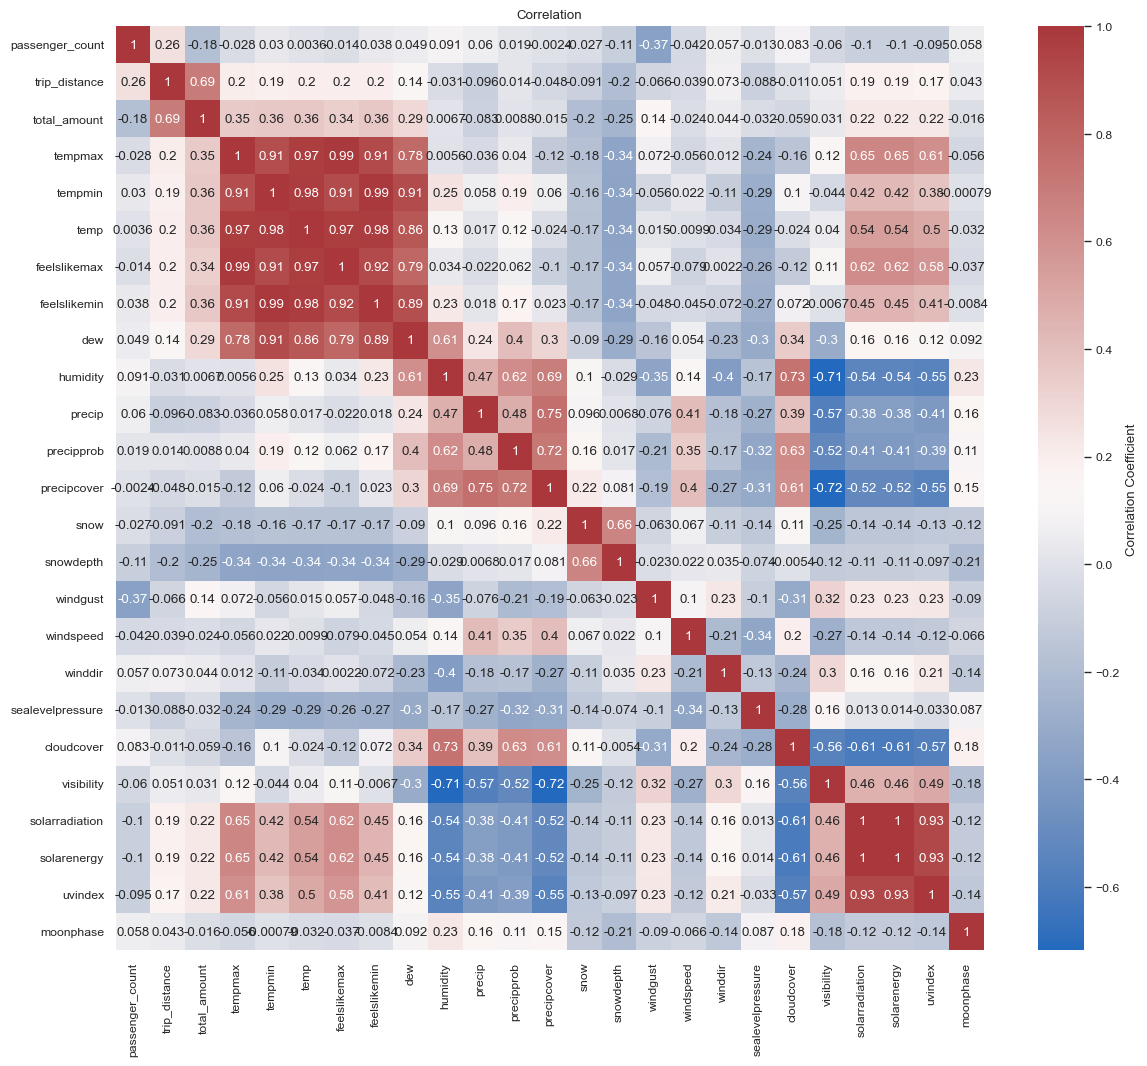

In [10]:
fig, ax = plt.subplots(figsize=(14, 12))

sns.set_theme()
sns.set_context("paper")

sns.heatmap(t1.corr(), annot=True, ax=ax, cmap='vlag',
            cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation")
plt.show()

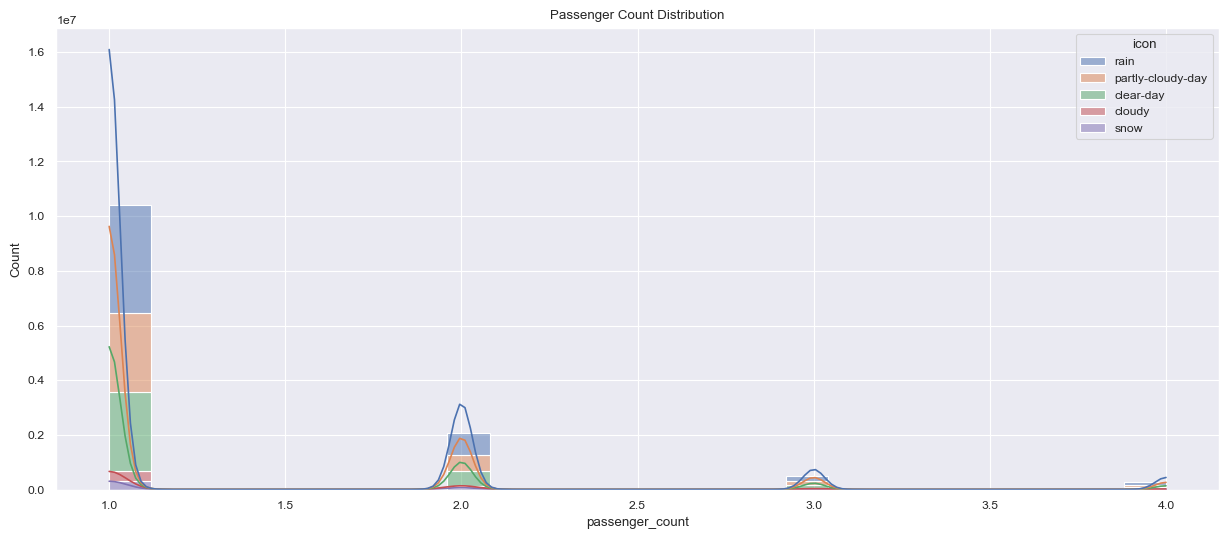

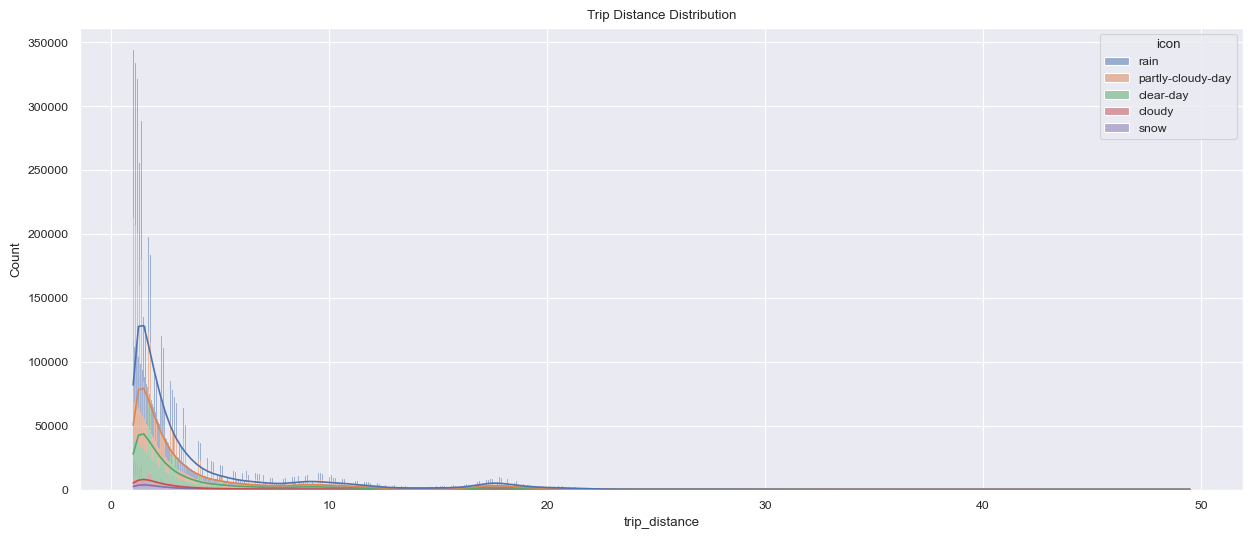

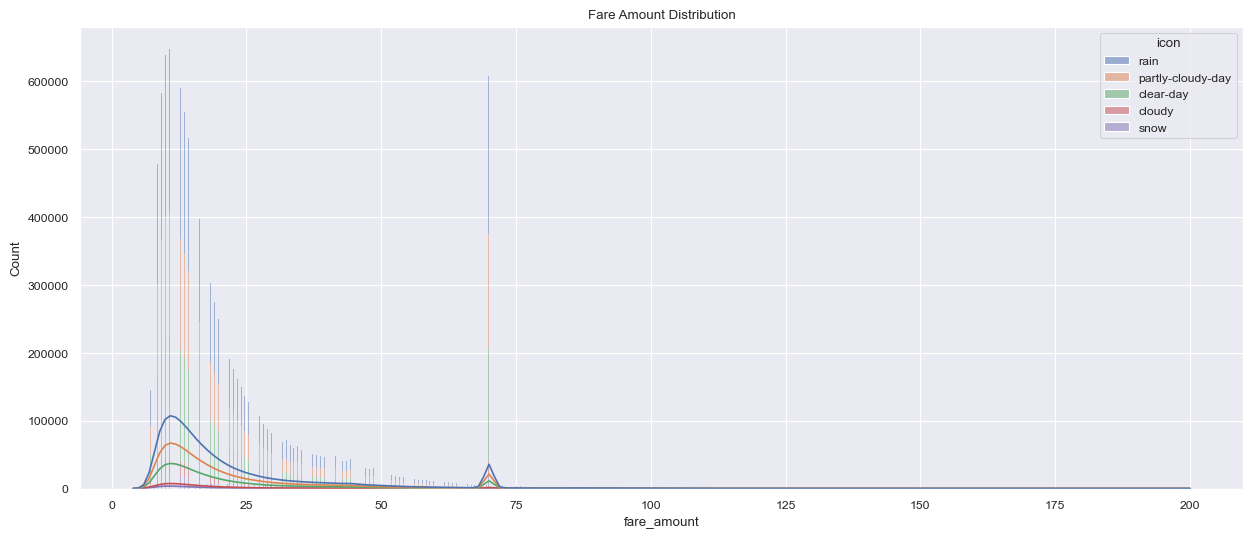

In [11]:
# passenger_count 
plt.figure(figsize=(15, 6))
sns.histplot(data=data, x='passenger_count', hue='icon', kde=True, multiple='stack')
plt.title('Passenger Count Distribution')
plt.show()

#  trip_distance
plt.figure(figsize=(15, 6))
sns.histplot(data=data, x='trip_distance', hue='icon', kde=True, multiple='stack')
plt.title('Trip Distance Distribution')
plt.show()

# fare_amount 
plt.figure(figsize=(15, 6))
sns.histplot(data=data, x='fare_amount', hue='icon', kde=True, multiple='stack')
plt.title('Fare Amount Distribution')
plt.show()


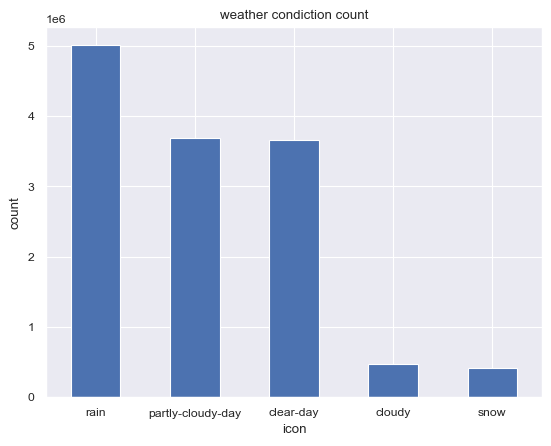

In [12]:
data['icon'].value_counts().plot(kind='bar', rot=0, ylabel='count', title='weather condiction count')
plt.show()


In [13]:
weather_effect = ['trip_distance', 'total_amount', 'icon', 'tip_amount']

data_tip = data[data['tip_amount']>0]

# Group by 'icon' and calculate max, min, and mean
aggregated_data = data_tip[weather_effect].groupby('icon').agg(['max', 'min', 'mean'])

# Flatten the MultiIndex columns
aggregated_data.columns = ['_'.join(col).strip() for col in aggregated_data.columns.values]


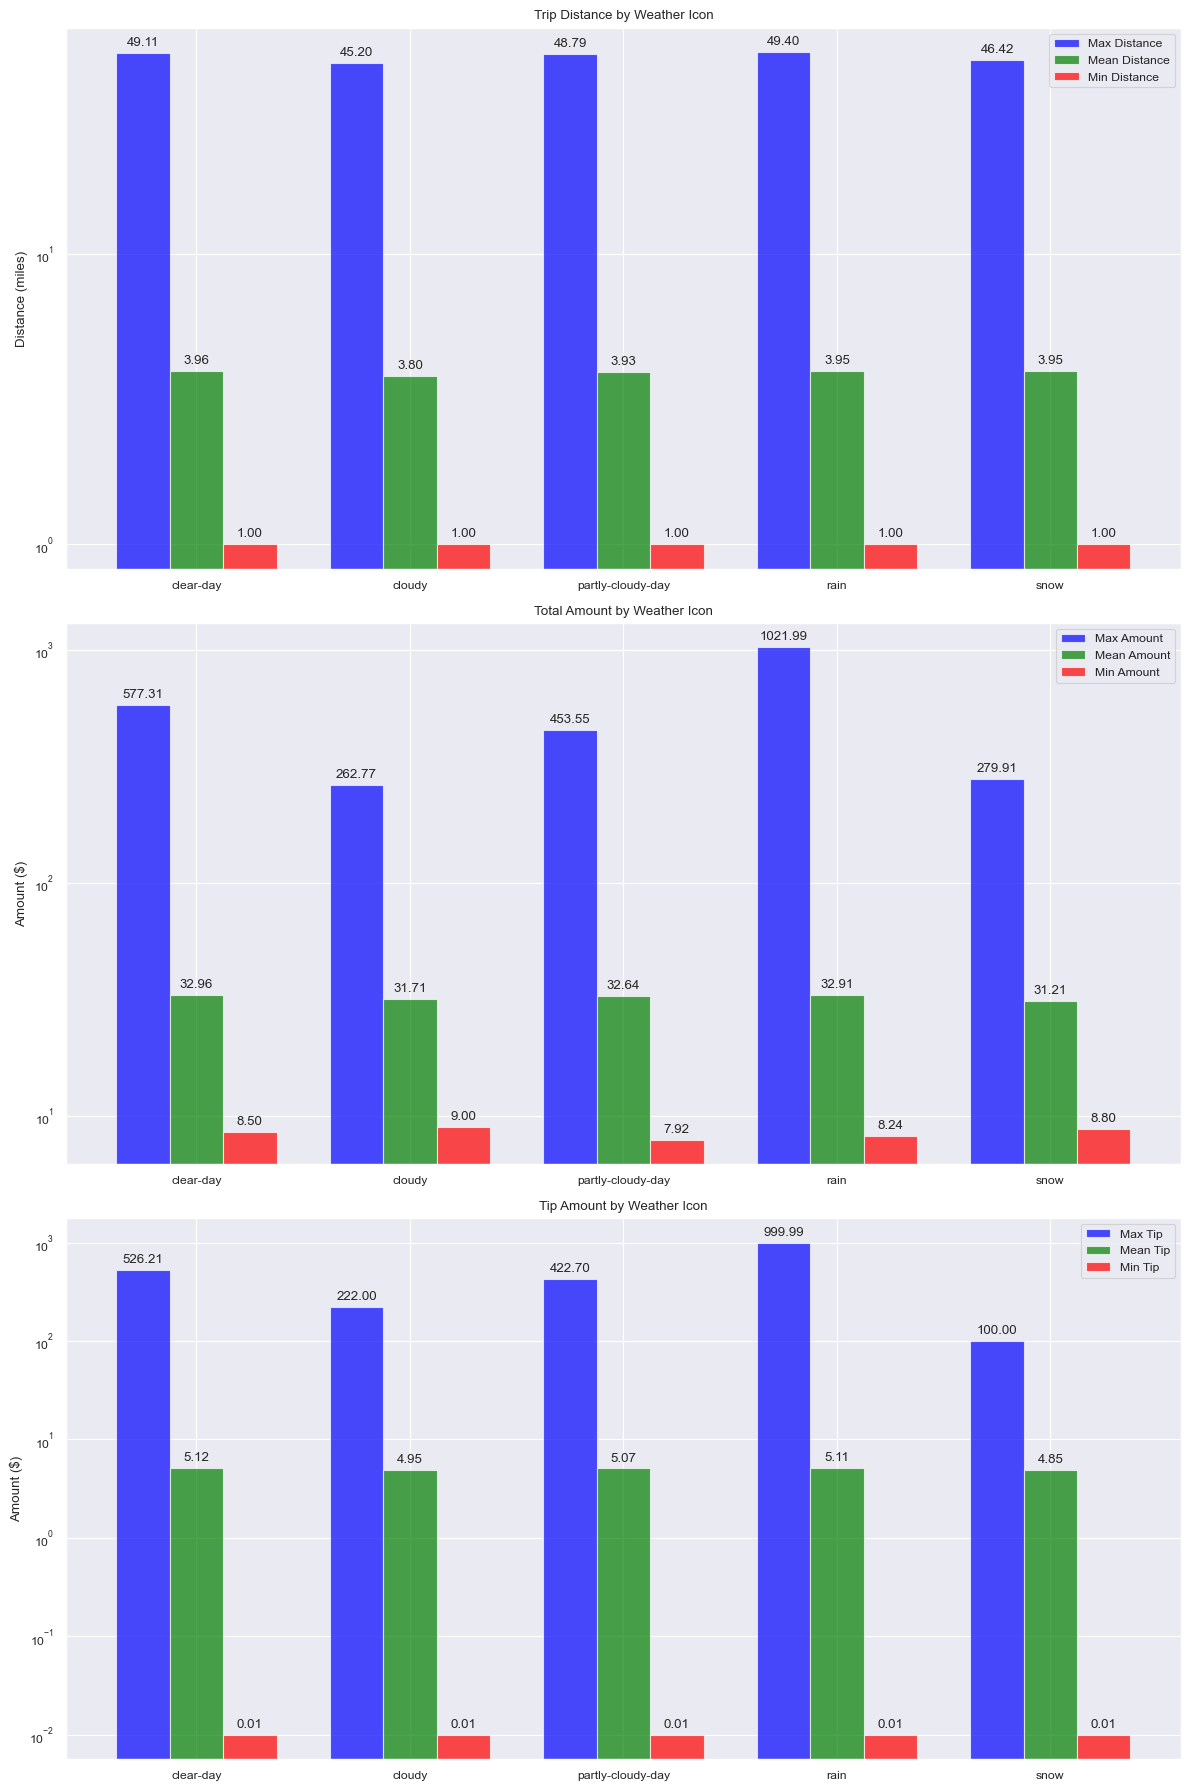

In [14]:
aggregated_data = aggregated_data.reset_index()

# Data provided by the user
icons = aggregated_data["icon"]
x = np.arange(len(icons))  # Label locations
width = 0.25  # Width of the bars

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Plot for trip distances
rects1 = axs[0].bar(x - width, aggregated_data["trip_distance_max"], width, label='Max Distance', color='blue', alpha=0.7)
rects2 = axs[0].bar(x, aggregated_data["trip_distance_mean"], width, label='Mean Distance', color='green', alpha=0.7)
rects3 = axs[0].bar(x + width, aggregated_data["trip_distance_min"], width, label='Min Distance', color='red', alpha=0.7)
axs[0].set_title('Trip Distance by Weather Icon')
axs[0].set_ylabel('Distance (miles)')
axs[0].set_xticks(x)
axs[0].set_xticklabels(icons)
axs[0].set_yscale('log')
axs[0].legend()

# Add values on bars
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        axs[0].annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Plot for total amount
rects1 = axs[1].bar(x - width, aggregated_data["total_amount_max"], width, label='Max Amount', color='blue', alpha=0.7)
rects2 = axs[1].bar(x, aggregated_data["total_amount_mean"], width, label='Mean Amount', color='green', alpha=0.7)
rects3 = axs[1].bar(x + width, aggregated_data["total_amount_min"], width, label='Min Amount', color='red', alpha=0.7)
axs[1].set_title('Total Amount by Weather Icon')
axs[1].set_ylabel('Amount ($)')
axs[1].set_xticks(x)
axs[1].set_xticklabels(icons)
axs[1].set_yscale('log')
axs[1].legend()

# Add values on bars
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        axs[1].annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

# Plot for tip amount
rects1 = axs[2].bar(x - width, aggregated_data["tip_amount_max"], width, label='Max Tip', color='blue', alpha=0.7)
rects2 = axs[2].bar(x, aggregated_data["tip_amount_mean"], width, label='Mean Tip', color='green', alpha=0.7)
rects3 = axs[2].bar(x + width, aggregated_data["tip_amount_min"], width, label='Min Tip', color='red', alpha=0.7)
axs[2].set_title('Tip Amount by Weather Icon')
axs[2].set_ylabel('Amount ($)')
axs[2].set_xticks(x)
axs[2].set_xticklabels(icons)
axs[2].set_yscale('log')
axs[2].legend()

# Add values on bars
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        axs[2].annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()
